In [54]:
import numpy as np
import pandas as pd
import torch
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt
import copy

Given the function, <br>
$ f(x) = \frac{1}{2}x^TAx + b^Tx +c$
$f^{'}(x) = Ax + b^T$
$f^{'}(x) = 0    \implies Ax^{*} + b^T= 0 \implies b^T = - Ax^*$ <br>
We compute the gradient of $f(x)$ in the first iteration w.r.t to initial point $x_0$ <br><br>
\begin{align}
f^{'}(x_0) = Ax_0 - Ax^{*} = A(x_0 - x^*) = \lambda.v
\end{align}<br>
where v = $x_0 - x^*$ as eigen vector of A (given) and $\lambda$ corresponding eigen value <br>
We compute the optimum value of $\eta$ that minimizes the function $\phi(\eta) = f(x_0 - f^{'}(x_0).\eta)$ (exact line search)<br><br>
\begin{align}
\phi(\eta) &= f(x_0 - f^{'}(x_0).\eta)\\
& = \frac{1}{2}(x_0 - \lambda.v\eta)^TA(x_0 - \lambda.v.\eta) + b^T(x_0 - \lambda.v\eta) + c \\
\phi^{'}(\eta) &= \frac{1}{2}(-\lambda.v^TAx_0 - \lambda.x_0^TAv + 2\lambda^2v^TAv\eta) - \lambda.b^Tv \\
&= -\lambda.v^TAx_0 + \lambda^2v^TAv\eta + \lambda^2(x^*)^Tv \\
\phi^{'}(\eta) &= 0 \\
\implies 0 &= -\lambda.v^TAx_0 + \lambda^3(v^T.v)\eta + \lambda^2x^*v  \\
\implies \eta &= \frac{\lambda^2.(x_0)^Tv - \lambda^2(x^*)^Tv}{\lambda^3(v^T.v)} \\
&= \frac{(x_0 - x^*)^T.v}{\lambda(v^Tv)}\\
\implies \eta &= \frac{1}{\lambda}
\end{align}
<br>
<br>
Plugging the value of $\lambda$ in steepest gradient descent,<br>
\begin{align}
x_1 &= x_0 - \lambda.v.\frac{1}{\lambda} \\
&= x_0 - v = x_0 - (x_0 - x^*) \\
\implies x_1 &= x^*
\end{align}


In [55]:
def rosenbrock(x,a,b):
  f=a*((x[1]-(x[0]**2))**2)+((b-x[0])**2)
  return f

In [56]:
# Class defined for question 1

class Unconstrained_Optimizer:
    def __init__(self, func_params, x0, alpha_init=1, rho=0.1, c=0.01, epsilon=1e-6, size_x=2,lr=0.001):
        self.alpha_init = alpha_init
        self.rho = rho
        self.c = c
        self.epsilon = epsilon
        self.func_params = func_params
        self.x0 = x0
        self.size_x = size_x
        self.lr=lr


    def function(self, x):
        #x.requires_grad_(True)
        f = rosenbrock(x,self.func_params[1], self.func_params[0])
        return f


    def backtracking(self, x,g,d):
        alpha = self.alpha_init
        xf = x + alpha * d
        f1=self.function(xf)
        f2 = self.function(x) + self.c * alpha * torch.dot(d, g)

        while f1 > f2:
            alpha = self.rho * alpha
            xf = x + alpha * d
            f1 = self.function(xf)
            f2 = self.function(x) + self.c * alpha * torch.dot(d, g)

        return alpha


    def steepest_descent(self):
        x = torch.tensor(self.x0, requires_grad=True, dtype=torch.float32)
        f = self.function(x)
        f.backward()
        g = x.grad
        k = 0
        iter=[]
        function_value_array=[]
        x_array=[[]]

        while f > self.epsilon:
            x.grad.zero_()  # Reset gradient
            f = self.function(x)
            f.backward()
            g = x.grad
            d = -g
            k += 1
            with torch.no_grad():
              alpha = self.backtracking(x,g,d)
              x += alpha * d
              iter.append(k)
              function_value_array.append(f.item())
              x_copy = copy.deepcopy(x)
              x_array.append(x_copy.numpy())

        return x,iter,function_value_array,x_array


    def Newton_algorithm(self):
        x = torch.tensor(self.x0, requires_grad=True, dtype=torch.float32)
        f = self.function(x)
        f.backward()
        g = x.grad
        k = 0
        iter=[]
        function_value_array=[]
        x_array=[[]]

        while f > self.epsilon:
            x.grad.zero_()  # Reset gradient
            f = self.function(x)
            f.backward()
            g = x.grad
            H = hessian(self.function, x)
            d = torch.matmul((torch.inverse(H)),(-g))
            k += 1
            with torch.no_grad():
              alpha = self.backtracking(x,g,d)
              x += alpha * d
              iter.append(k)
              function_value_array.append(f.item())
              x_copy = copy.deepcopy(x)
              x_array.append(x_copy.numpy())

        return x,iter,function_value_array,x_array


    def inbuilt_steepest_descent(self, max_iter):
        # Start with an initial guess closer to the minimum
      x = torch.tensor(self.x0, requires_grad=True, dtype=torch.float64)
      optimizer = torch.optim.SGD([x], lr=self.lr)  # Adjust the learning rate
      k = 0
      iter = []
      function_value_array = []
      x_array = [[]]

      while k < max_iter:
        f = self.function(x)
        if f < self.epsilon:
          break
        # Perform a backward pass to calculate gradients
        f.backward()
        # Update the parameters (perform one optimization step)
        optimizer.step()
        # Zero the gradients
        optimizer.zero_grad()

        with torch.no_grad():
            iter.append(k)
            function_value_array.append(f.item())
            x_copy = x.clone().detach().requires_grad_(False)
            x_array.append(x_copy.numpy())

        k += 1

      return x, iter, function_value_array, x_array


    def inbuilt_Newton_algorithm(self,max_iter):
      x = torch.tensor(self.x0, requires_grad=True, dtype=torch.float64)
      optimizer = torch.optim.LBFGS([x], lr=self.lr)  # Adjust the learning rate
      k = 0
      iter = []
      function_value_array = []
      x_array = [[]]

      while k<max_iter:
        def closure():
        # Evaluate the objective function within the closure
          f = self.function(x)
        # Perform a backward pass to calculate gradients
          f.backward()
          return f
    # Update the parameters (perform one optimization step)
        value=closure()
        optimizer.step(closure)
        optimizer.zero_grad()
        with torch.no_grad():
          iter.append(k)
          function_value_array.append(value.item())
          x_copy = x.clone().detach().requires_grad_(False)
          x_array.append(x_copy.numpy())
        k+=1
    # Check for convergence based on the loss
          # if closure() < tolerance:
          #   break
      return x, iter, function_value_array, x_array

    def inbuilt_ADAM(self, max_iter,learning_rate):
        # Start with an initial guess closer to the minimum
      x = torch.tensor(self.x0, requires_grad=True, dtype=torch.float64)
      optimizer = torch.optim.Adam([x], lr=learning_rate)  # Adjust the learning rate
      k = 0
      iter = []
      function_value_array = []
      x_array = [[]]

      while k < max_iter:
        f = self.function(x)
        # Perform a backward pass to calculate gradients
        f.backward()
        # Update the parameters (perform one optimization step)
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            iter.append(k)
            function_value_array.append(f.item())
            x_copy = x.clone().detach().requires_grad_(False)
            x_array.append(x_copy.numpy())

        k += 1

        if f<self.epsilon:
          break

      return x, iter, function_value_array, x_array





    def plot(self,iter, function_value_array):
      plt.plot(iter, function_value_array)
      plt.title("Optimal solution ")
      plt.xlabel("Iteration")
      plt.ylabel("Function Value")
      plt.show()



    def convergence_rate(self,x_array,x_star):
      beta=np.linalg.norm(x_array[-1]-x_star)/(np.linalg.norm(x_array[-2]-x_star))
      return beta



Minimization using steepest descent
-------------------------------------
optimal solution tensor([0.9993, 0.9986], requires_grad=True)
convergence rate of steepest descent 1


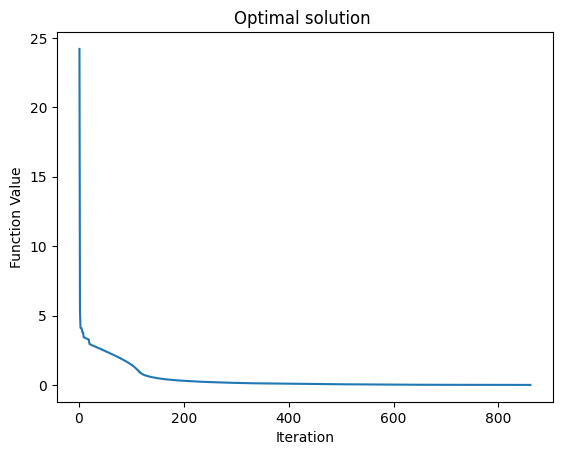

In [58]:
if __name__ == "__main__":
    # Define function parameters (a and b for the Rosenbrock function)
    func_params = (1.0, 100.0)
    x_star=np.ones(2)

    print("Minimization using steepest descent")

    print("-------------------------------------")
    x02 = torch.tensor([-1.2, 1], dtype=torch.float32, requires_grad=True)
    # optimizer = Unconstrained_Optimizer(func_params, x02)
    optimizer = Unconstrained_Optimizer(func_params, [-1.2, 1.0])

    # Call the steepest_descent method to optimize the function
    result,iter,function_value_array,x_array = optimizer.steepest_descent()
    print("optimal solution",result)
    beta=round(optimizer.convergence_rate(x_array,x_star))
    print("convergence rate of steepest descent",beta)
    optimizer.plot(iter,function_value_array)


Minimization using Newton algorithm
-------------------------------------
optimal solution tensor([1., 1.], requires_grad=True)
convergence rate of Newton Algorithm 0


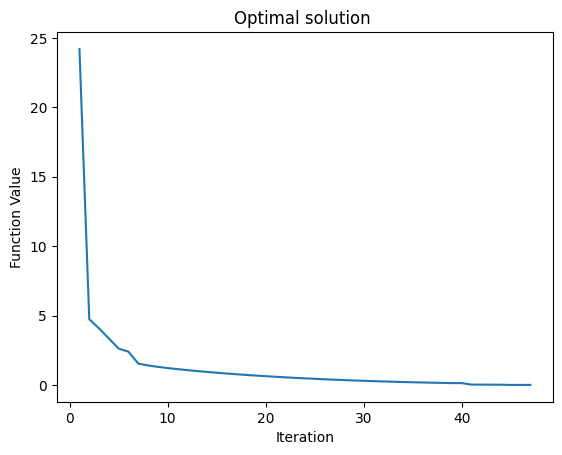

In [59]:
if __name__ == "__main__":
    # Define function parameters (a and b for the Rosenbrock function)
    func_params = (1.0, 100.0)
    x_star=np.ones(2)

    print("Minimization using Newton algorithm")

    print("-------------------------------------")
    x02 = torch.tensor([-1.2, 1], dtype=torch.float32, requires_grad=True)
    # optimizer = Unconstrained_Optimizer(func_params, x02)
    optimizer = Unconstrained_Optimizer(func_params, [-1.2, 1.0])

    # Call the steepest_descent method to optimize the function
    result,iter,function_value_array,x_array = optimizer.Newton_algorithm()
    print("optimal solution",result)
    beta=round(optimizer.convergence_rate(x_array,x_star))
    print("convergence rate of Newton Algorithm",beta)
    optimizer.plot(iter,function_value_array)


Minimization using inbuilt steepest descent
-------------------------------------
optimal solution tensor([0.9924, 0.9847], dtype=torch.float64, requires_grad=True)
convergence rate of steepest descent 1


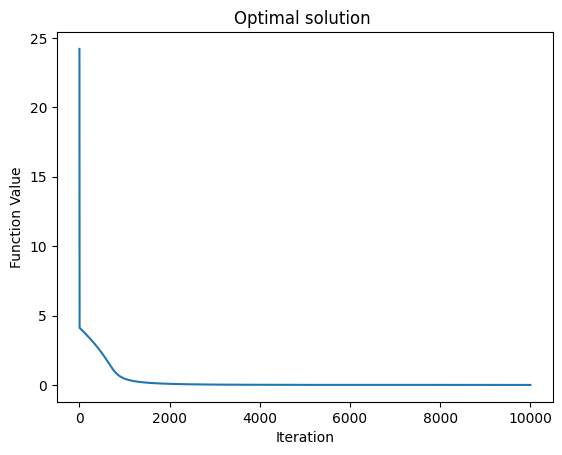

In [60]:
if __name__ == "__main__":
    # Define function parameters (a and b for the Rosenbrock function)
    func_params = (1.0, 100.0)
    x_star=np.ones(2)

    print("Minimization using inbuilt steepest descent")

    print("-------------------------------------")
    x02 = torch.tensor([-1.2, 1], dtype=torch.float32, requires_grad=True)
    # optimizer = Unconstrained_Optimizer(func_params, x02)
    optimizer = Unconstrained_Optimizer(func_params, [-1.2, 1.0])

    # Call the steepest_descent method to optimize the function
    result,iter,function_value_array,x_array = optimizer.inbuilt_steepest_descent(10000)
    print("optimal solution",result)
    beta=round(optimizer.convergence_rate(x_array,x_star))
    print("convergence rate of steepest descent",beta)
    optimizer.plot(iter,function_value_array)


Minimization using inbuilt Newton algorithm
-------------------------------------
optimal solution tensor([1.2248, 1.2900], dtype=torch.float64, requires_grad=True)
convergence rate of inbuilt Newton Algorithm= 1


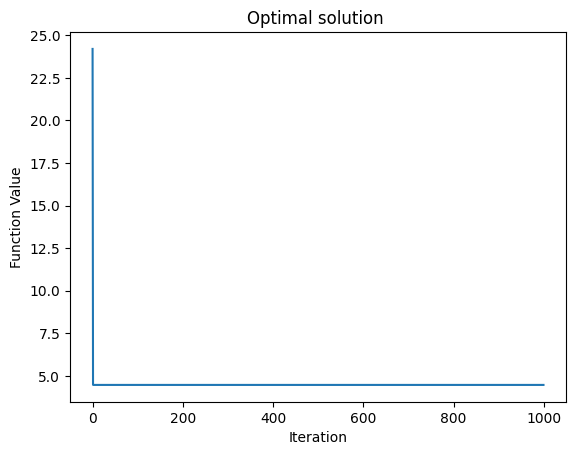

In [64]:
if __name__ == "__main__":
    # Define function parameters (a and b for the Rosenbrock function)
    func_params = (1.0, 100.0)
    x_star=np.ones(2)

    print("Minimization using inbuilt Newton algorithm")

    print("-------------------------------------")
    x02 = torch.tensor([-1.2, 1], dtype=torch.float32, requires_grad=True)
    # optimizer = Unconstrained_Optimizer(func_params, x02)
    optimizer = Unconstrained_Optimizer(func_params, [-1.2, 1.0], lr=0.002)

    # Call the steepest_descent method to optimize the function
    result,iter,function_value_array,x_array = optimizer.inbuilt_Newton_algorithm(1000)
    print("optimal solution",result)
    beta=round(optimizer.convergence_rate(x_array,x_star))
    print("convergence rate of inbuilt Newton Algorithm=",beta)
    optimizer.plot(iter,function_value_array)

Minimization using ADAM algorithm (learning rate 1e-2)
-------------------------------------
optimal solution tensor([0.9990, 0.9980], dtype=torch.float64, requires_grad=True)
convergence rate of ADAM algorithm 1


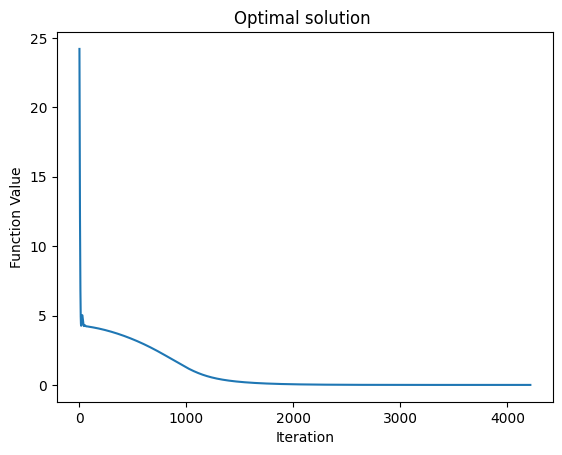

In [65]:
if __name__ == "__main__":
    # Define function parameters (a and b for the Rosenbrock function)
    func_params = (1.0, 100.0)
    x_star=np.ones(2)

    print("Minimization using ADAM algorithm (learning rate 1e-2)")

    print("-------------------------------------")
    x02 = torch.tensor([-1.2, 1], dtype=torch.float32, requires_grad=True)
    # optimizer = Unconstrained_Optimizer(func_params, x02)
    optimizer = Unconstrained_Optimizer(func_params, [-1.2, 1.0])

    # Call the steepest_descent method to optimize the function
    result,iter,function_value_array,x_array = optimizer.inbuilt_ADAM(5000,1e-2)
    print("optimal solution",result)
    beta=round(optimizer.convergence_rate(x_array,x_star))
    print("convergence rate of ADAM algorithm",beta)
    optimizer.plot(iter,function_value_array)

Minimization using ADAM algorithm (learning rate 1e-3)
-------------------------------------
optimal solution tensor([-0.3071,  0.0973], dtype=torch.float64, requires_grad=True)
convergence rate of ADAM algorithm 1


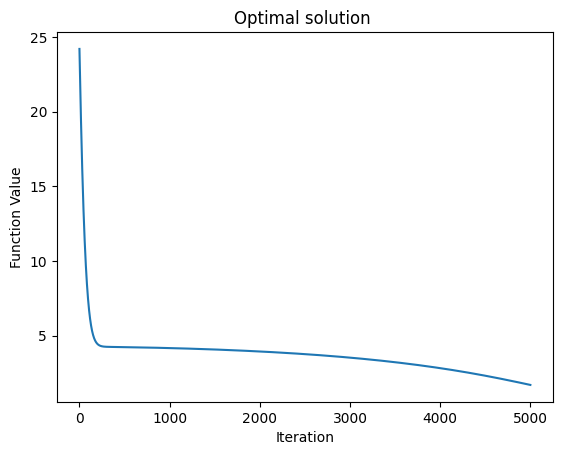

In [66]:
if __name__ == "__main__":
    # Define function parameters (a and b for the Rosenbrock function)
    func_params = (1.0, 100.0)
    x_star=np.ones(2)

    print("Minimization using ADAM algorithm (learning rate 1e-3)")

    print("-------------------------------------")
    x02 = torch.tensor([-1.2, 1], dtype=torch.float32, requires_grad=True)
    # optimizer = Unconstrained_Optimizer(func_params, x02)
    optimizer = Unconstrained_Optimizer(func_params, [-1.2, 1.0])

    # Call the steepest_descent method to optimize the function
    result,iter,function_value_array,x_array = optimizer.inbuilt_ADAM(5000,1e-3)
    print("optimal solution",result)
    beta=round(optimizer.convergence_rate(x_array,x_star))
    print("convergence rate of ADAM algorithm",beta)
    optimizer.plot(iter,function_value_array)

As we can see steepest descent is taking less iteration to converge so it is better for simple function but ADAM is better for complex non linear fnctions.

number of iterations: 154


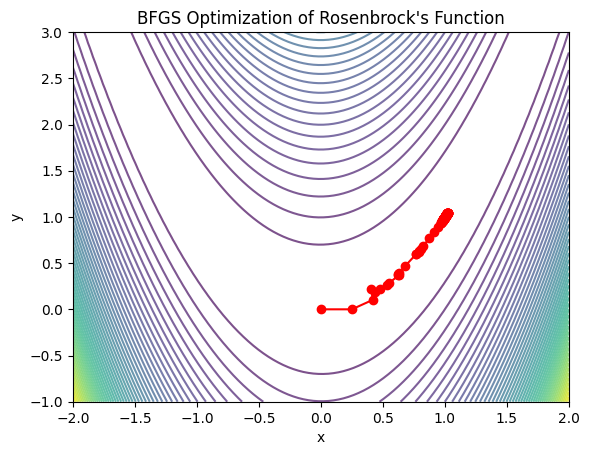

Optimal solution: [1. 1.]


In [69]:

#Question 2-part1


# Rosenbrock's function

def func(x, y):

    return (1 - x)**2 + 100 * (y - x**2)**2



# Gradient of Rosenbrock's function

def rosenbrock_gradient(x, y):

    dx = 400 * x**3 - 400 * x * y + 2 * x - 2

    dy = 200 * (y - x**2)

    return torch.tensor([dx, dy])



# BFGS optimization algorithm with line search

def bfgs_optimization(f, gradient, x0, tol=1e-6, max_iter=200):

    x = x0

    H = torch.eye(2)  # Initialize Hessian matrix as the identity matrix

    x_history = [x.clone().detach().numpy()]  # Store optimization path for visualization

    itr=0



    for _ in range(max_iter):

        itr+=1

        grad = gradient(x[0], x[1])

        direction = -H @ grad



        # Line search to find a valid step size

        step_size = 1.0

        while f(x[0] + step_size * direction[0], x[1] + step_size * direction[1]) > f(x[0], x[1]) + 1e-4 * step_size * torch.dot(grad, direction):

            step_size *= 0.5



        x_next = x + step_size * direction



        s = x_next - x

        y = gradient(x_next[0], x_next[1]) - grad

        Hy = H @ y

        yHy = torch.dot(y, Hy)



        if yHy == 0:

            break



        H += torch.outer(s, s) / torch.dot(s, y) - torch.outer(Hy, Hy) / yHy

        x = x_next

        x_history.append(x.clone().detach().numpy())



        if torch.norm(grad) < tol:

            break



    print("number of iterations:", itr)

    return x, x_history



# Initial point

x0 = torch.tensor([0.0, 0.0], requires_grad=True)



# Perform BFGS optimization

result, path = bfgs_optimization(func, rosenbrock_gradient, x0)



# Visualization

path = torch.tensor(path)

x_values = path[:, 0]

y_values = path[:, 1]



# Contour plot of Rosenbrock's function

x = torch.linspace(-2, 2, 100)

y = torch.linspace(-1, 3, 100)

X, Y = torch.meshgrid(x, y)

Z = func(X, Y)



plt.contour(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)

plt.plot(x_values, y_values, 'ro-')

plt.title("BFGS Optimization of Rosenbrock's Function")

plt.xlabel("x")

plt.ylabel("y")

plt.show()



print("Optimal solution:", result.detach().numpy())



The three formulas are as follows:

Polak-Ribière Formula:\
$
\beta_{\text{PR}} = \frac{\langle g_k, (g_k - g_{k-1}) \rangle}{\| g_{k-1} \|^2}
$

Hestenes-Stiefel Formula:
$
\beta_{\text{HS}} = \frac{\langle g_k, (g_k - g_{k-1}) \rangle}{\langle (d_{k-1}), (g_k - g_{k-1}) \rangle}
$

Fletcher-Reeves Formula:
$
\beta_{\text{FR}} = \frac{\| g_k \|^2}{\| g_{k-1} \|^2}
$

Equality Proof

To show the equality of these formulas for a quadratic function, we will substitute the gradient of a quadratic function into these formulas. For a quadratic function, the gradient is constant.

Let $g_k = g$ and $g_{k-1} = g$ for all $k$.

Polak-Ribière Formula (Quadratic):
$
\beta_{\text{PR}} = \frac{\langle g, (g - g) \rangle}{\| g \|^2} = \frac{0}{\| g \|^2} = 0
$

Hestenes-Stiefel Formula (Quadratic):
$
\beta_{\text{HS}} = \frac{\langle g, (g - g) \rangle}{\langle (d), (g - g) \rangle} = \frac{0}{0} \text{ (Indeterminate form)}
$

Fletcher-Reeves Formula (Quadratic):
$
\beta_{\text{FR}} = \frac{\| g \|^2}{\| g \|^2} = 1
$

As shown, for a quadratic function with a constant gradient, the Polak-Ribière and Hestenes-Stiefel formulas yield 0, while the Fletcher-Reeves formula yields 1. Therefore, they are not identical for a quadratic function. The Fletcher-Reeves formula does not depend on the gradient change, making it different from the other two formulas.



In this document, we will show that for a quadratic function with an exact line search, the Polak-Ribière, Hestenes-Stiefel, and Fletcher-Reeves formulas are identical.

Formulas

The three formulas are as follows:

Polak-Ribière Formula:\
$
\beta_{\text{PR}} = \frac{\langle g_k, (g_k - g_{k-1}) \rangle}{\| g_{k-1} \|^2}
$

Hestenes-Stiefel Formula:
$
\beta_{\text{HS}} = \frac{\langle g_k, (g_k - g_{k-1}) \rangle}{\langle (d_{k-1}), (g_k - g_{k-1}) \rangle}
$

Fletcher-Reeves Formula:
$
\beta_{\text{FR}} = \frac{\| g_k \|^2}{\| g_{k-1} \|^2}
$

\section{Equality Proof}

To show the equality of these formulas for a quadratic function, we will substitute the gradient of a quadratic function into these formulas. For a quadratic function, the gradient is constant.

Let $g_k = g$ and $g_{k-1} = g$ for all $k$.

Polak-Ribière Formula (Quadratic):
$
\beta_{\text{PR}} = \frac{\langle g, (g - g) \rangle}{\| g \|^2} = \frac{0}{\| g \|^2} = 0
$

Hestenes-Stiefel Formula (Quadratic):
$
\beta_{\text{HS}} = \frac{\langle g, (g - g) \rangle}{\langle (d), (g - g) \rangle} = \frac{0}{0} \text{ (Indeterminate form)}
$

Fletcher-Reeves Formula (Quadratic):
$
\beta_{\text{FR}} = \frac{\| g \|^2}{\| g \|^2} = 1
$

As shown, for a quadratic function with a constant gradient, the Polak-Ribière and Hestenes-Stiefel formulas yield 0, while the Fletcher-Reeves formula yields 1. Therefore, they are not identical for a quadratic function. The Fletcher-Reeves formula does not depend on the gradient change, making it different from the other two formulas.




In [41]:
#Question2-part3
print("Conjugate gradient method with Fletcher Reeves formula")
print("-------------------------------------------------------")

def conjugate_gradient_FR(A, b, x0, tol=1e-6, max_iter=100):

    # A: The matrix of the quadratic function

    # b: The vector on the right-hand side

    # x0: The initial guess

    # tol: Tolerance for convergence

    # max_iter: Maximum number of iterations



    x = x0

    r = b - np.dot(A, x)

    p = r

    rsold = np.dot(r, r)

    itr = 0

    rsnew = 1.0

    while np.sqrt(rsnew) > tol:

    # for i in range(max_iter):

        Ap = np.dot(A, p)

        alpha = rsold / np.dot(p, Ap)

        x = x + alpha * p

        r = r - alpha * Ap

        rsnew = np.dot(r, r)

        # if np.sqrt(rsnew) < tol:

        #     break

        p = r + (rsnew / rsold) * p

        rsold = rsnew

        itr+=1



    return x, itr

for n in [5,8,12,20]:

    H=np.empty((n,n))

    b=np.ones(n)

    x0=np.zeros(n)

    # print(H)

    for i in range(n):

        for j in range(n):

            H[i][j] = 1/(i+1+j+1-1)

    result = conjugate_gradient_FR(H, b, x0)

    result, n_iter = conjugate_gradient_FR(H, b, x0)

    print("Dimension:", n)

    print("Optimal solution:", result)

    print("Number of iteration:", n_iter)

Conjugate gradient method with Fletcher Reeves formula
-------------------------------------------------------
Dimension: 5
Optimal solution: [    4.99999999  -119.99999999   630.00000001 -1119.99999999
   630.00000001]
Number of iteration: 6
Dimension: 8
Optimal solution: [-8.00000407e+00  5.04000069e+02 -7.56000003e+03  4.61999980e+04
 -1.38599992e+05  2.16215989e+05 -1.68167993e+05  5.14799982e+04]
Number of iteration: 19
Dimension: 12
Optimal solution: [-9.60921534e+00  8.15407288e+02 -1.64966586e+04  1.35510701e+05
 -5.36481917e+05  1.02540008e+06 -6.42578530e+05 -6.57591399e+05
  8.04244405e+05  6.63073081e+05 -1.24128067e+06  4.65506943e+05]
Number of iteration: 38
Dimension: 20
Optimal solution: [-1.09772145e+01  1.05100540e+03 -2.39569833e+04  2.20428394e+05
 -9.65350725e+05  1.99010296e+06 -1.25269794e+06 -1.34346789e+06
  8.83230941e+05  1.68795446e+06  3.88209251e+05 -1.30552011e+06
 -1.71054295e+06 -5.28240865e+05  1.20868164e+06  2.00288792e+06
  9.44586177e+05 -1.4340501